In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_table('SMSSpamCollection', header=None, quoting=3, names=['class', 'message'])

In [3]:
print len(df)
print df.shape
print df.head()

5574
(5574, 2)
  class                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
df_train, df_test, y_train, y_test = train_test_split(df['message'], df['class'], test_size=0.33, random_state=42)

In [6]:
# vectorizing using tf-idf

vectorizer = TfidfVectorizer(use_idf=True)

X_train = vectorizer.fit_transform(df_train)
X_test = vectorizer.transform(df_test)

In [7]:
# Standard Logistic Regression

clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

        ham       0.99      0.98      0.99      1585
       spam       0.90      0.94      0.92       255

avg / total       0.98      0.98      0.98      1840

[[1558   27]
 [  15  240]]


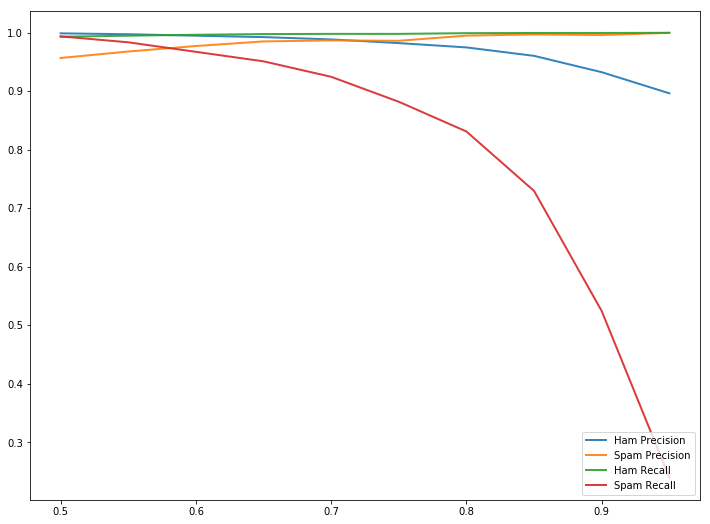

In [8]:
# The model is quite good, but the precision for spam recognition could be better - we don't want to have 
# important messages in the spam folder. Let's see if we can aquire better precision using different values of threshold 
# of Logistic Regression classificator, not losing to much on recall.

thresholds = [x / 100. for x in range(50,100, 5)]

def custom_predict(clf, X, t):   
    pr = clf.predict_proba(X)
    indices = [1 if p[1] > t else 0 for p in pr]
    
    return clf.classes_[indices]

# Let's collect classification results for different values of threshold
results = []
for t in thresholds:
    y_pred = custom_predict(clf, X_train, t)
    results.append(precision_recall_fscore_support(y_train, y_pred))
    
# And plot the results
plt.rcParams["figure.figsize"] = [12,9]

plt.plot(thresholds, [x[0][0] for x in results], lw=2, alpha=0.9, label="Ham Precision")
plt.plot(thresholds, [x[0][1] for x in results], lw=2, alpha=0.9, label="Spam Precision")
plt.plot(thresholds, [x[1][0] for x in results], lw=2, alpha=0.9, label="Ham Recall")
plt.plot(thresholds, [x[1][1] for x in results], lw=2, alpha=0.9, label="Spam Recall")

plt.legend(loc='lower right')

In [9]:
# From the chart above, one can notice that for t = 0.7 we get quite a noticable boost in Spam precision (then in flattens), 
# without loosing too much on Spam recall. 
# We can check this value of threshold on the test data. Doing that we can observe that we indeed aquire a noticable boost in 
# Spam precision. Spam recall is at solid 0.89 level. Weighted f1-score is 0.98 so the same as in standard model with t = 0.5. 
# Moreover, we get only 5 ham messages classified as spam (so the result is more than 5 times better than in standard model).

y_pred = custom_predict(clf, X_test, 0.7)

print classification_report(y_test, y_pred)
print confusion_matrix(y_test, y_pred)

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      1585
       spam       0.98      0.89      0.93       255

avg / total       0.98      0.98      0.98      1840

[[1580    5]
 [  29  226]]


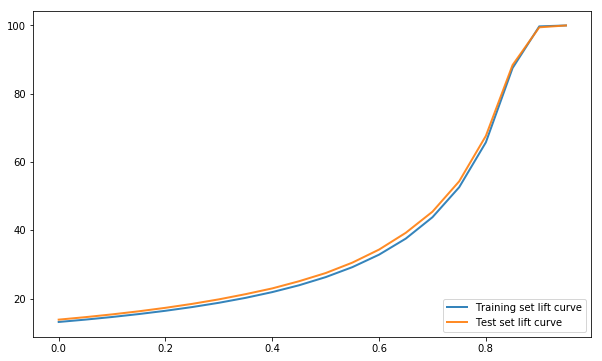

In [10]:
# Cumultative Lift Charts

# scoring training and test sets
y_tr_pred = clf.predict_proba(X_train)[:,1]
y_ts_pred = clf.predict_proba(X_test)[:,1]

# sorting them
tr = sorted(zip(y_tr_pred, y_train == 'spam'), key=lambda x: x[0], reverse=True)
ts = sorted(zip(y_ts_pred, y_test == 'spam'), key=lambda x: x[0], reverse=True)

# average score in each bin
cumulated = {0: [], 1: []}
for i, s in enumerate([tr, ts]):
    scores = []
    for group in np.array_split(s, 20):
        scores += [x[1] for x in group]
        cumulated[i].append(np.mean(scores) * 100)

# plotting
bins = [x / 100. for x in reversed(range(0 , 100, 5))]

plt.rcParams["figure.figsize"] = [10,6]

plt.plot(bins, cumulated[0], lw=2, alpha=0.9, label="Training set lift curve")
plt.plot(bins, cumulated[1], lw=2, alpha=0.9, label="Test set lift curve")

plt.legend(loc='lower right')

# Cumultative Lift Charts for training and test sets are smooth and close to each other. Thus, the model
# is less likely to be overtrained or overfitted.

In [11]:
# We aquired satisfactory model with very high precision for spam detection and solid recall. However, using a custom
# threshold value might not be the best solution for some instances of data, that we did not test during our
# modeling process. Therefore, one can be still worried about the recall of the model. That is why we will try to
# explore different approaches and try to find even better model.